EE488 Exercise #1: Connect Google Drive and using Custom Dataset
====
TA : JongSuk Kim

TA's E-mail : jskpop@kaist.ac.kr

## Questions
- Please use QnA board in KLMS as a main communication channel. When you post questions, please make it public so that all students can share the information. Please use the prefix "[Exercise 1]" in the subject for all questions regarding this practice

## Instruction
- In this practice, we will implement custom datasets and data loaders to use various datasets for machine learning, and study how to use the data uploaded to personal Google drive in colab.

- Before you start the practice, **download & unzip the file from the link below, and upload it to your Google Drive.** 

*Train image link: https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz*

*Ground Truth link: https://www.robots.ox.ac.uk/~vgg/data/flowers/17/trimaps.tgz*




### Unzip and Upload Folder

You can unzip your folder with "tar -xvzf [FOLDER NAME]"

ex1) tar -xvzf 17flowers.tgz

ex2) tar -xvzf trimaps.tgz
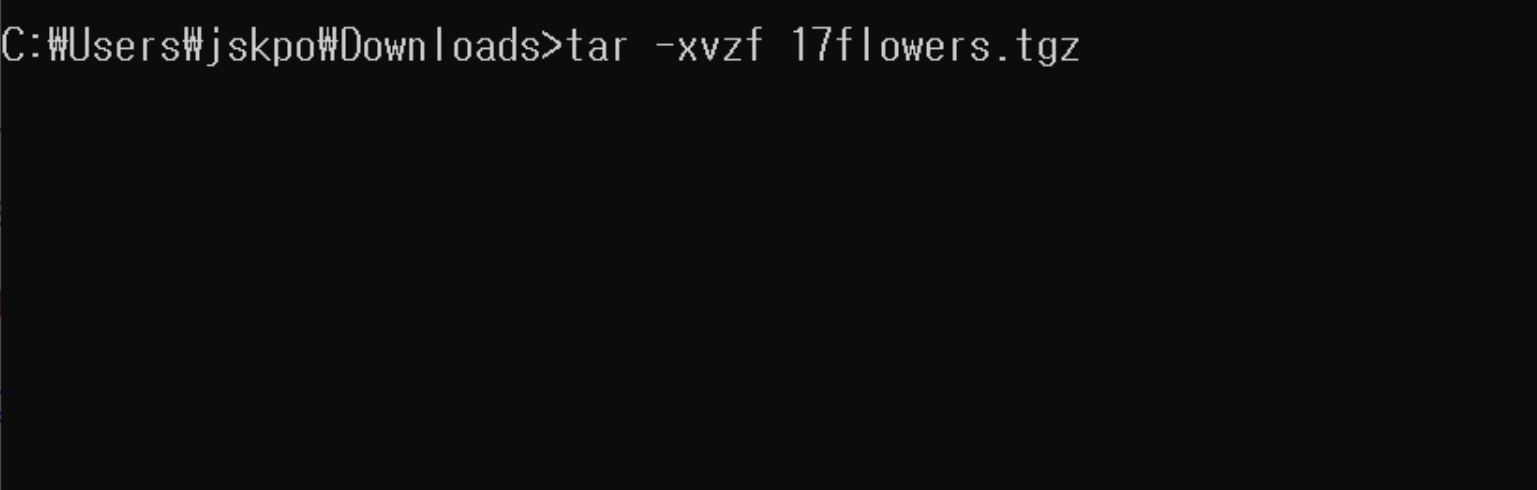

After uploading the file, check the folder is configured as shown in the picture below.

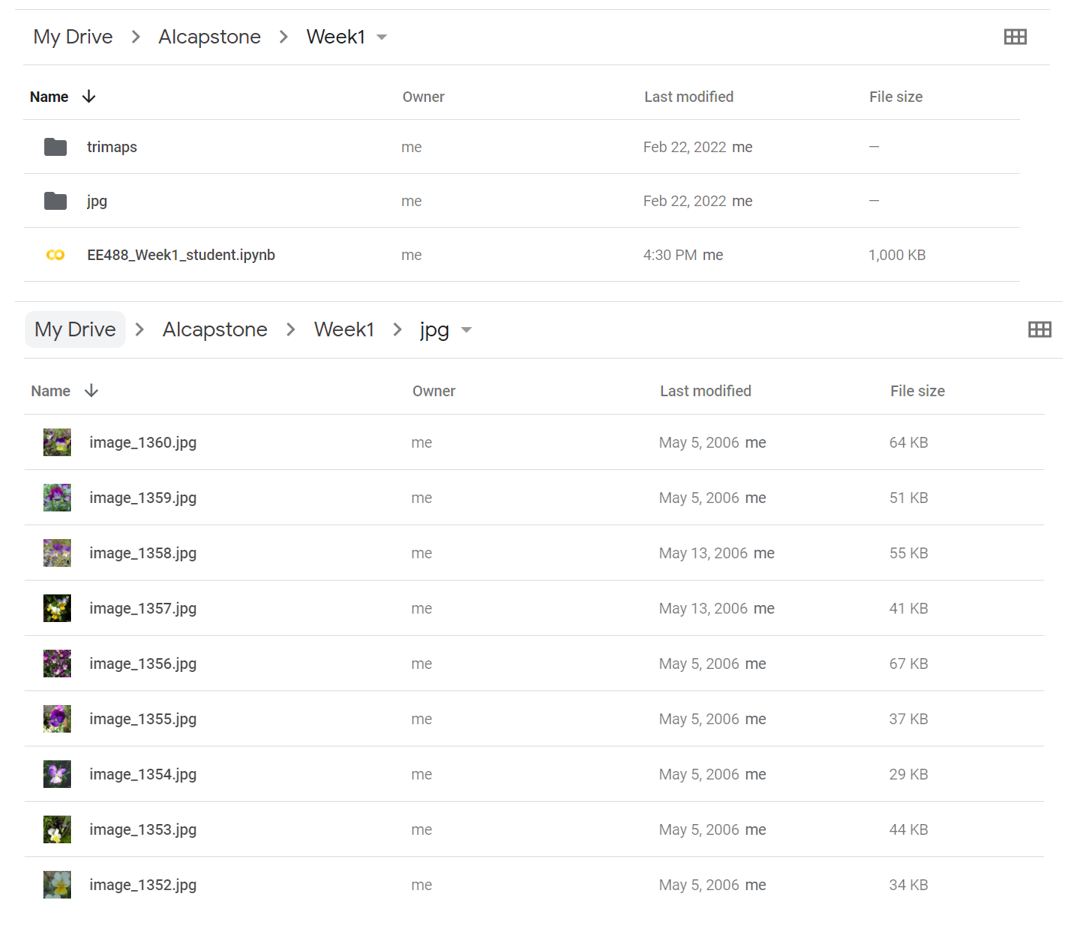

### Connect to your Google Drive.

It is required for loading the data.

Enter your authorization code to access your drive.


In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


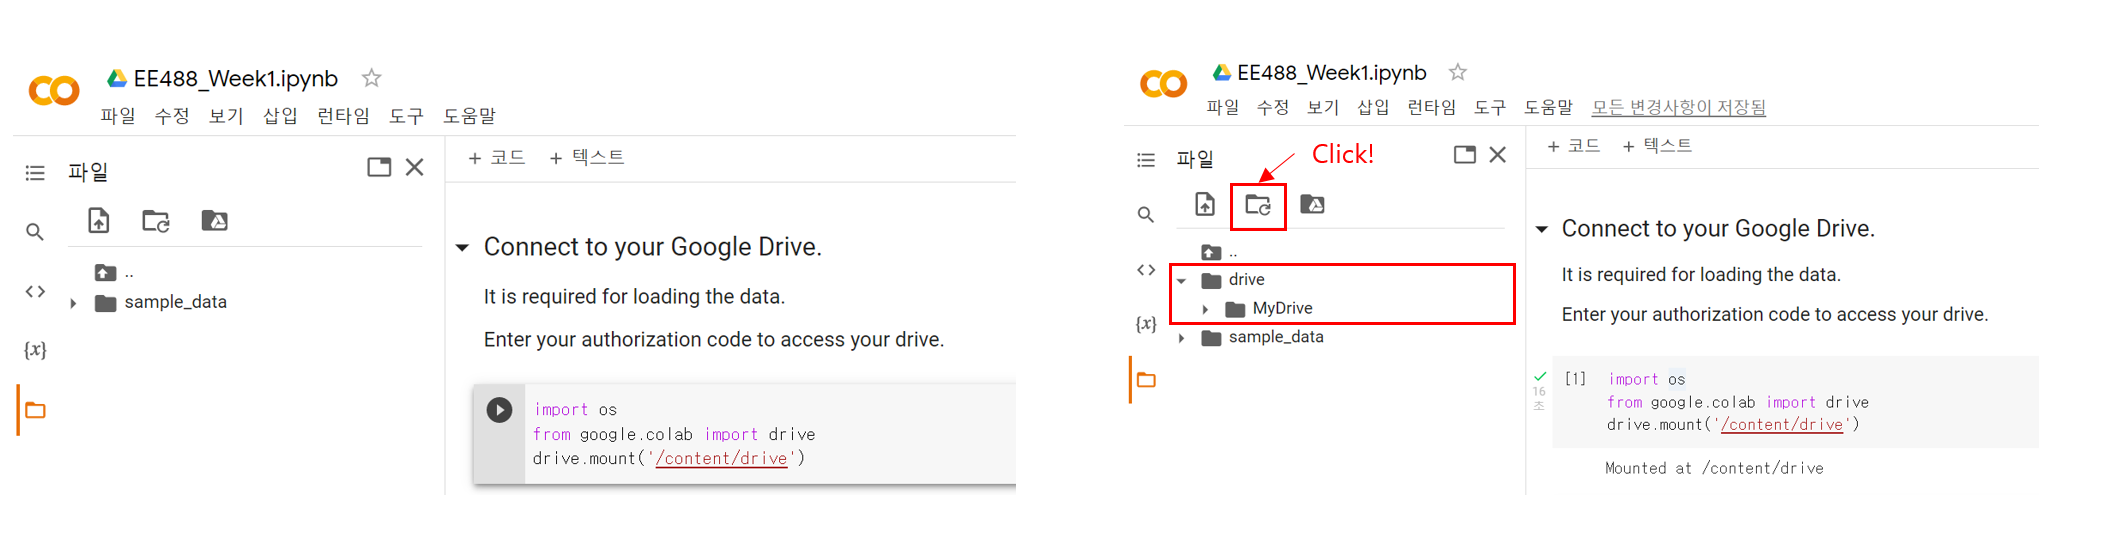

Make sure all the data is uploaded well.

Output(# of image and segmentation map): 1362(1360+2), 849(848+1)

*Train image folder contain 2 text files, segmentation map folder contain 1 file list mat file*

In [ ]:
# set data folder path in your google drive 
root_path = '/content/drive/MyDrive/AIcapstone/Week1'

# set image folder and segmentation map folder path
image_path = os.path.join(root_path, 'jpg')
segmap_path = os.path.join(root_path, 'trimaps')

# check image nums for each directory
print(len(os.listdir(image_path)))
print(len(os.listdir(segmap_path)))

1362
849


### Import modules and make image loader

PIL(pillow) - Python Image Library, you can check detail information in [here](https://pillow.readthedocs.io/en/stable/)

torch(PyTorch) - One of the most famous machine learning library. You can check detail information in [here](https://pytorch.org/)

torchvision - It is a library for Computer Vision that goes hand in hand with PyTorch. You can check library document in [here](https://pytorch.org/vision/stable/index.html)

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

### Custom Dataset

In [ ]:
class CustomFlowerDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        image_folder = os.path.join(root, 'jpg')

        self.image_list = os.listdir(image_folder)
        # image_list: ['image_0001','image_0002',...]

    def __getitem__(self, i):
        image_path = os.path.join(self.root, 'jpg', self.image_list[i])
        # -> ROOT/jpg/image_0001

        # load image
        image = pil_loader(image_path)
        
        # apply transform
        image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.image_list)

In [ ]:
train_transform = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
train_dataset = CustomFlowerDataset(root_path, train_transform)
print(len(train_dataset))

1362


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle=False)
train_iter = iter(train_loader)
data = train_iter.next()
data.shape

torch.Size([4, 3, 224, 224])

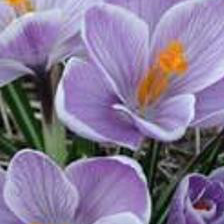

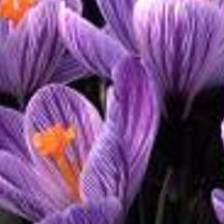

In [ ]:
image0 = transforms.ToPILImage()(data[2])
image1 = transforms.ToPILImage()(data[3])

# display image
display(image0)
display(image1)

### Practice: Find Problems and Return label
Above Custom Dataset have some problems. Find wrong points and fix custom dataset.

Add a function to return the label. Image index indicates label

file name - **image_x**: The image with **x** is 1-80 is first label, 81-160 is second label, ... ,1280-1360 is last(17th) label


In [ ]:
class CustomFlowerDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.image_list = []
        self.labels = []
        for idx in range(1,1361):
            # use zfill function for make image name '1' -> '0001'
            # ['image_0001.jpg','image_0002.jpg',...]
            image_name = 'image_'+ str(idx).zfill(4) +'.jpg'
            self.image_list.append(image_name)

            # make label with number in image name
            label = (idx-1)//80
            # [0,0,0,0,...,1,1,....,17, 17]
            self.labels.append(label)
    
    def __getitem__(self, i):
        image_path = os.path.join(self.root, 'jpg', self.image_list[i])

        # load image
        image = pil_loader(image_path)

        # apply transform
        image = self.transform(image)

        # get label
        label = self.labels[i]
        
        return image, label
    
    def __len__(self):
        return len(self.image_list)

In [ ]:
train_transform = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
train_dataset = CustomFlowerDataset(root_path,train_transform)
print(len(train_dataset))

1360


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle=False)
train_iter = iter(train_loader)
data, label = train_iter.next()
data.shape

torch.Size([16, 3, 224, 224])

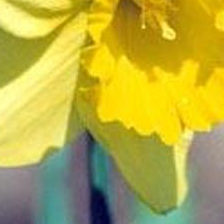

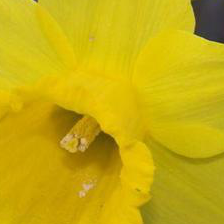

In [ ]:
image0 = transforms.ToPILImage()(data[14])
image1 = transforms.ToPILImage()(data[15])

# display image
display(image0)
display(image1)

### Practice: Return Segmentation map with image

When you want to train model for segmentation, only images with he label should be used.

 Let's make custom dataset that only returns images with segmentation label. 

In [ ]:
class CustomFlowerDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.image_list = []
        self.seg_list = []
        for idx in range(1,1361):
            # make segmentation label name 
            seg_name = 'image_' + str(idx).zfill(4) + '.png'
            seg_path = os.path.join(root, 'trimaps', seg_name)

            # check if segmentation label exists
            # ROOT/trimaps/image_0001.png -> True
            # ROOT/trimaps/image_0035.png -> False
            if os.path.exists(seg_path):
                # make image name
                image_name = 'image_' + str(idx).zfill(4) + '.jpg'

                # append image name and segmentation label path
                self.image_list.append(image_name)
                self.seg_list.append(seg_path)

                # image_list: ['image_0001.jpg','image_0002',...]
                # seg_list: ['{ROOT}/trimaps/image_0001.png',...]
    
    def __getitem__(self, i):
        image_path = os.path.join(self.root, 'jpg', self.image_list[i])
        
        # load image 
        image = pil_loader(image_path)
        
        # apply transform
        image = self.transform(image)

        # load segmentation label image
        # you don't need to make segmap path. Already list contain root directory
        segmap = pil_loader(self.seg_list[i])

        # apply transform
        segmap = self.transform(segmap)

        return image, segmap
    
    def __len__(self):
        return len(self.seg_list)

In [ ]:
train_transform = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
train_dataset = CustomFlowerDataset(root_path,train_transform)
print(len(train_dataset))

848


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle=False)
train_iter = iter(train_loader)
image, segmap = train_iter.next()
image.shape

torch.Size([4, 3, 224, 224])

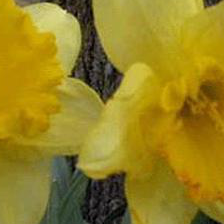

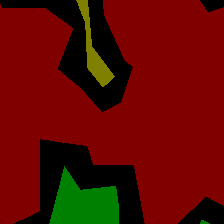

In [ ]:
train_image = transforms.ToPILImage()(image[0])
seg_image = transforms.ToPILImage()(segmap[0])

display(train_image)
display(seg_image)

### Practice: Return train image, label, segmentation map at one time

In [ ]:
class CustomFlowerDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.image_list = []
        self.seg_list = []
        self.labels = []

        for idx in range(1,1361):
            # make segmentation label name 
            seg_name = 'image_' + str(idx).zfill(4) +".png"
            seg_path = os.path.join(root, 'trimaps', seg_name)

            # check if segmentation label exists
            # ROOT/trimaps/image_0001.png -> True
            # ROOT/trimaps/image_0035.png -> False
            if os.path.exists(seg_path):
                # make image name
                image_name = 'image_' + str(idx).zfill(4) + ".jpg"

                # append image name and segmentation label path
                self.image_list.append(image_name)
                self.seg_list.append(seg_path)
                self.labels.append((idx-1)//80)

                # image_list: ['image_0001.jpg','image_0002',...]
                # seg_list: ['{ROOT}/trimaps/image_0001.png',...]
    
    def __getitem__(self, i):
        image_path = os.path.join(self.root, 'jpg', self.image_list[i])
        
        # load image 
        image = pil_loader(image_path)
        
        # apply transform
        image = self.transform(image)

        # load segmentation label image
        # you don't need to make segmap path. Already list contain root directory
        segmap = pil_loader(self.seg_list[i])

        # apply transform
        segmap = self.transform(segmap)

        label = self.labels[i]
        return image, segmap, label
    
    def __len__(self):
        return len(self.seg_list)

In [ ]:
train_transform = transforms.Compose([
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()
                                      ])
train_dataset = CustomFlowerDataset(root = root_path, transform=train_transform)
print(len(train_dataset))

848


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 4, shuffle=True)
train_iter = iter(train_loader)
image, segmap, label = train_iter.next()
image.shape

torch.Size([4, 3, 224, 224])

In [ ]:
label

tensor([ 4,  3, 14, 14])

In [ ]:
idx = 3
train_image = transforms.ToPILImage()(image[idx])
seg_image = transforms.ToPILImage()(segmap[idx])
image_label = label[idx]

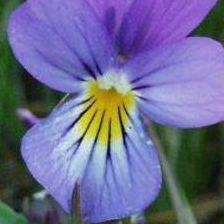

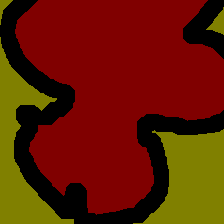

tensor(16)


In [ ]:
display(train_image)
display(seg_image)
print(image_label)